In [1]:
import cv2, json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../debug/result-rect-image.json', 'r') as f:
    results = json.load(f)
list(results.keys())

['info', 'prediction']

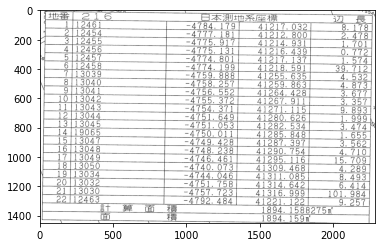

In [3]:
# load image
img = cv2.imread('../debug/20200619173238005_x355X2640y337Y1787.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)

In [4]:
def sort_clockwise(a):
    """
    Sort corners points (x1, y1, x2, y2, ... clockwise from topleft), shape = (*, 2)
    :ref https://gist.github.com/flashlib/e8261539915426866ae910d55a3f9959
    :param a: ndarray, shape is (points nums, 2=(x,y))
    :return a: ndarray, shape is (points nums... clockwise from topleft, 2=(x,y))
    """

    # get centroids, shape=(1,2=(cx,cy))
    center = a.mean(axis=0).reshape((1, 2))

    sorted_inds = np.argsort(np.arctan2(a[:, 1]-center[:, 1], a[:, 0]-center[:, 0]))

    return np.take(a, sorted_inds, axis=0)

In [5]:
# reconstruct correct coordinates
h, w, _ = img.shape

# shape = (annotation_num, points_num, 2=(x,y))
polys = np.array([result['bbox'] for result in results['prediction']])
texts = np.array([result['text'] for result in results['prediction']])

polys[..., 0] *= w
polys[..., 1] *= h
polys = polys.astype(int)
polys = np.array([sort_clockwise(poly) for poly in polys])

# sort top-left y with ascending order
# shape = (annotation_num,)
tly_indices = np.argsort(polys[:, 0, 1])
polys = np.take(polys, tly_indices, axis=0)
texts = np.take(texts, tly_indices, axis=0)

_polys = polys.copy()
_texts = texts.copy()

polys.shape

(129, 4, 2)

In [6]:
polys = _polys.copy()
texts = _texts.copy()

error = 50
concat_error = 15

# target_poly: shape = (1, points_num, 2=(x, y))
# target_text: shape = (1,)
target_poly = polys[:1]
target_text = texts[:1]

# polys: shape = (cand_num, points_num, 2=(x, y))
# texts: shape = (cand_num,)
polys = polys[1:]
texts = texts[1:]

# extract the values with top-left y within the error for target_poly's one
# shape = (cand_num,)
line_bindices = np.abs(polys[:, 0, 1] - target_poly[:, 0, 1]) < error

# line_polys: shape = (column_num, points_num, 2=(x,y))
# line_texts: shape = (column_num,)
line_polys = np.concatenate((target_poly, polys[line_bindices]), axis=0)
line_texts = np.concatenate((target_text, texts[line_bindices]), axis=0)

polys = polys[np.logical_not(line_bindices)]
texts = texts[np.logical_not(line_bindices)]
if polys.shape[0] == 0:
    pass

# sort top-left x with ascending order
tlx_indices = np.argsort(line_polys[:, 0, 0])
line_polys = np.take(line_polys, tlx_indices, axis=0)
line_texts = np.take(line_texts, tlx_indices, axis=0)

_line_polys = line_polys.copy()
_line_texts = line_texts.copy()

line_polys.shape
_line_texts

array(["554\n216\n112461\n2 12454\n3 12455\n4|12456\n5 12457\n6 12458\n713039\n8 13040\n9 13041\n10 13042\n11 13043\n12|13044\n13 13045\n14 19065\n15 13047\n16 13048\n17 13049\n18 13050\n19 13034\n20 13032\n21 13030\n22 12463\nt.\n日本測地系座標\n-4784.179\n-4777.181\n-4775.917\n-4775.131\n-4774.801\n-4774. 199\n-4759.888\n-4758.257\n-4756.552\n-4755.372\n-4754.371\n-4751.649\n-4751.053\n-4750.011\n-4749.428\n-4748.238\n-4746.461\n-4740.073\n-4744.046\n-4751.758\n-4757.723\n-4792.484\n積\n積\n41217.032\n41212.800\n41214.931\n41216.439\n41217. 137\n41218.591\n41255.635\n41259.863\n41264.428\n41267.911\n41271.115\n41280.626\n41282.534\n41285.848\n41287.397\n41290.754\n41295. 116\n41309.468\n41311.085\n41314.642\n41316.999\n41221.122\n1894. 1588275m\n1894. 159m'\n長\n8. 178\n2.478\n1.701\n0.772\n1.574\n39.712\n4.532\n4.873\n3.677\n3.357\n9.893\n1.999\n3.474\n1.655\n3.562\n4.710\n15.709\n4.289\n8. 493\n6.414\n101.984\n9.257\n算 面\n",
       '216', '日本', '測', '地', '系', '座標', '長', '554'], dtype='<U824'

In [7]:
line_polys = _line_polys.copy()
line_texts = _line_texts.copy()

row = []
while line_polys.shape[0] > 0:

    column_text = line_texts[0]

    # extract the values with top-left x(min) within the error for target_poly's maximum x
    concat_index = 1
    for r_index in range(1, line_polys.shape[0]):
        left_poly_maxX = line_polys[r_index-1, :, 0].max()
        right_poly_minX = line_polys[r_index, :, 0].min()
        if np.abs(left_poly_maxX - right_poly_minX) < concat_error:
            concat_index = r_index + 1
            column_text += line_texts[r_index]
        else:
            break

    # update
    line_polys = line_polys[concat_index:]
    line_texts = line_texts[concat_index:]

    row += [column_text]

row

["554\n216\n112461\n2 12454\n3 12455\n4|12456\n5 12457\n6 12458\n713039\n8 13040\n9 13041\n10 13042\n11 13043\n12|13044\n13 13045\n14 19065\n15 13047\n16 13048\n17 13049\n18 13050\n19 13034\n20 13032\n21 13030\n22 12463\nt.\n日本測地系座標\n-4784.179\n-4777.181\n-4775.917\n-4775.131\n-4774.801\n-4774. 199\n-4759.888\n-4758.257\n-4756.552\n-4755.372\n-4754.371\n-4751.649\n-4751.053\n-4750.011\n-4749.428\n-4748.238\n-4746.461\n-4740.073\n-4744.046\n-4751.758\n-4757.723\n-4792.484\n積\n積\n41217.032\n41212.800\n41214.931\n41216.439\n41217. 137\n41218.591\n41255.635\n41259.863\n41264.428\n41267.911\n41271.115\n41280.626\n41282.534\n41285.848\n41287.397\n41290.754\n41295. 116\n41309.468\n41311.085\n41314.642\n41316.999\n41221.122\n1894. 1588275m\n1894. 159m'\n長\n8. 178\n2.478\n1.701\n0.772\n1.574\n39.712\n4.532\n4.873\n3.677\n3.357\n9.893\n1.999\n3.474\n1.655\n3.562\n4.710\n15.709\n4.289\n8. 493\n6.414\n101.984\n9.257\n算 面\n",
 '216',
 '日本測地系座標',
 '長554']

In [8]:
polys = _polys.copy()
texts = _texts.copy()

error = 50
concat_error = 15

ret = []
while polys.shape[0] > 0:
    # target_poly: shape = (1, points_num, 2=(x, y))
    # target_text: shape = (1,)
    target_poly = polys[:1]
    target_text = texts[:1]

    # polys: shape = (cand_num, points_num, 2=(x, y))
    # texts: shape = (cand_num,)
    polys = polys[1:]
    texts = texts[1:]

    # extract the values with top-left y within the error for target_poly's one
    # shape = (cand_num,)
    line_bindices = np.abs(polys[:, 0, 1] - target_poly[:, 0, 1]) < error

    # line_polys: shape = (column_num, points_num, 2=(x,y))
    # line_texts: shape = (column_num,)
    line_polys = np.concatenate((target_poly, polys[line_bindices]), axis=0)
    line_texts = np.concatenate((target_text, texts[line_bindices]), axis=0)

    polys = polys[np.logical_not(line_bindices)]
    texts = texts[np.logical_not(line_bindices)]
    if polys.shape[0] == 0:
        break

    # sort top-left x with ascending order
    tlx_indices = np.argsort(line_polys[:, 0, 0])
    line_polys = np.take(line_polys, tlx_indices, axis=0)
    line_texts = np.take(line_texts, tlx_indices, axis=0)

    row = []
    while line_polys.shape[0] > 0:

        column_text = line_texts[0]

        # extract the values with top-left x(min) within the error for target_poly's maximum x
        concat_index = 1
        for r_index in range(1, line_polys.shape[0]):
            left_poly_maxX = line_polys[r_index-1, :, 0].max()
            right_poly_minX = line_polys[r_index, :, 0].min()
            if np.abs(left_poly_maxX - right_poly_minX) < concat_error:
                concat_index = r_index + 1
                column_text += line_texts[r_index]
            else:
                break

        # update
        line_polys = line_polys[concat_index:]
        line_texts = line_texts[concat_index:]

        row += [column_text]
    ret += [row]

ret

[["554\n216\n112461\n2 12454\n3 12455\n4|12456\n5 12457\n6 12458\n713039\n8 13040\n9 13041\n10 13042\n11 13043\n12|13044\n13 13045\n14 19065\n15 13047\n16 13048\n17 13049\n18 13050\n19 13034\n20 13032\n21 13030\n22 12463\nt.\n日本測地系座標\n-4784.179\n-4777.181\n-4775.917\n-4775.131\n-4774.801\n-4774. 199\n-4759.888\n-4758.257\n-4756.552\n-4755.372\n-4754.371\n-4751.649\n-4751.053\n-4750.011\n-4749.428\n-4748.238\n-4746.461\n-4740.073\n-4744.046\n-4751.758\n-4757.723\n-4792.484\n積\n積\n41217.032\n41212.800\n41214.931\n41216.439\n41217. 137\n41218.591\n41255.635\n41259.863\n41264.428\n41267.911\n41271.115\n41280.626\n41282.534\n41285.848\n41287.397\n41290.754\n41295. 116\n41309.468\n41311.085\n41314.642\n41316.999\n41221.122\n1894. 1588275m\n1894. 159m'\n長\n8. 178\n2.478\n1.701\n0.772\n1.574\n39.712\n4.532\n4.873\n3.677\n3.357\n9.893\n1.999\n3.474\n1.655\n3.562\n4.710\n15.709\n4.289\n8. 493\n6.414\n101.984\n9.257\n算 面\n",
  '216',
  '日本測地系座標',
  '長554'],
 ['112461', '-4784.179', '41217.032', '

# Use line

In [26]:
polys = _polys.copy()
texts = _texts.copy()

error = 50
concat_error = 15

# calculate the 2 centroids by (top-left, bottom-left) and (bottom-right, bottom-left)
# shape = (points_num, 2)
pts_left, pts_right = polys[:, [0, 3], :].mean(axis=1), polys[:, [1, 2], :].mean(axis=1)

# calculate direction vector, shape = (points_num, 2)
dirvec = pts_right - pts_left

# solve y=ax+b
# a,b shape = (points_num,)
A = (pts_right[:, 1] - pts_left[:, 1])/(pts_right[:, 0] - pts_left[:, 0])
B = pts_right[:, 1] - a*pts_right[:, 0]
f = lambda _x, _a, _b: _a*_x+_b

# sort b with ascending order, shape = (points_num,)
b_indices = np.argsort(B)
# sort
A = np.take(A, b_indices, axis=0)
B = np.take(B, b_indices, axis=0)
polys = np.take(polys, b_indices, axis=0)
texts = np.take(texts, b_indices, axis=0)
pts_left = np.take(pts_left, b_indices, axis=0)
pts_right = np.take(pts_right, b_indices, axis=0)

# target_poly: shape = (1, points_num, 2=(x, y))
# target_text: shape = (1,)
target_poly = polys[:1]
target_text = texts[:1]
a, b = A[0], B[0]

# polys: shape = (cand_num, points_num, 2=(x, y))
# texts: shape = (cand_num,)
polys = polys[1:]
texts = texts[1:]
pts_left = pts_left[1:]
pts_right = pts_right[1:]


# extract the values with top-left y within the error for target_poly's one
# shape = (cand_num,)
line_bindices = np.abs(f(pts_left[:, 0], a, b) - pts_left[:, 1]) < error

# line_polys: shape = (column_num, points_num, 2=(x,y))
# line_texts: shape = (column_num,)
line_polys = np.concatenate((target_poly, polys[line_bindices]), axis=0)
line_texts = np.concatenate((target_text, texts[line_bindices]), axis=0)

polys = polys[np.logical_not(line_bindices)]
texts = texts[np.logical_not(line_bindices)]
if polys.shape[0] == 0:
    pass

# sort top-left x with ascending order
tlx_indices = np.argsort(line_polys[:, 0, 0])
line_polys = np.take(line_polys, tlx_indices, axis=0)
line_texts = np.take(line_texts, tlx_indices, axis=0)

_line_polys = line_polys.copy()
_line_texts = line_texts.copy()

line_polys.shape
_line_texts

array(['554'], dtype='<U824')

In [30]:
polys = _polys.copy()
texts = _texts.copy()

error = 30
concat_error = 15

ret = []
while polys.shape[0] > 0:
    # calculate the 2 centroids by (top-left, bottom-left) and (bottom-right, bottom-left)
    # shape = (points_num, 2)
    pts_left, pts_right = polys[:, [0, 3], :].mean(axis=1), polys[:, [1, 2], :].mean(axis=1)

    # calculate direction vector, shape = (points_num, 2)
    dirvec = pts_right - pts_left

    # solve y=ax+b
    # a,b shape = (points_num,)
    A = (pts_right[:, 1] - pts_left[:, 1])/(pts_right[:, 0] - pts_left[:, 0])
    B = pts_right[:, 1] - a*pts_right[:, 0]
    f = lambda _x, _a, _b: _a*_x+_b

    # sort b with ascending order, shape = (points_num,)
    b_indices = np.argsort(B)
    # sort
    A = np.take(A, b_indices, axis=0)
    B = np.take(B, b_indices, axis=0)
    polys = np.take(polys, b_indices, axis=0)
    texts = np.take(texts, b_indices, axis=0)
    pts_left = np.take(pts_left, b_indices, axis=0)
    pts_right = np.take(pts_right, b_indices, axis=0)

    # target_poly: shape = (1, points_num, 2=(x, y))
    # target_text: shape = (1,)
    target_poly = polys[:1]
    target_text = texts[:1]
    a, b = A[0], B[0]

    # polys: shape = (cand_num, points_num, 2=(x, y))
    # texts: shape = (cand_num,)
    polys = polys[1:]
    texts = texts[1:]
    pts_left = pts_left[1:]
    pts_right = pts_right[1:]


    # extract the values with top-left y within the error for target_poly's one
    # shape = (cand_num,)
    line_bindices = np.abs(f(pts_left[:, 0], a, b) - pts_left[:, 1]) < error

    # line_polys: shape = (column_num, points_num, 2=(x,y))
    # line_texts: shape = (column_num,)
    line_polys = np.concatenate((target_poly, polys[line_bindices]), axis=0)
    line_texts = np.concatenate((target_text, texts[line_bindices]), axis=0)

    polys = polys[np.logical_not(line_bindices)]
    texts = texts[np.logical_not(line_bindices)]
    if polys.shape[0] == 0:
        break

    # sort top-left x with ascending order
    tlx_indices = np.argsort(line_polys[:, 0, 0])
    line_polys = np.take(line_polys, tlx_indices, axis=0)
    line_texts = np.take(line_texts, tlx_indices, axis=0)

    row = []
    while line_polys.shape[0] > 0:

        column_text = line_texts[0]

        # extract the values with top-left x(min) within the error for target_poly's maximum x
        concat_index = 1
        for r_index in range(1, line_polys.shape[0]):
            left_poly_maxX = line_polys[r_index-1, :, 0].max()
            right_poly_minX = line_polys[r_index, :, 0].min()
            if np.abs(left_poly_maxX - right_poly_minX) < concat_error:
                concat_index = r_index + 1
                column_text += line_texts[r_index]
            else:
                break

        # update
        line_polys = line_polys[concat_index:]
        line_texts = line_texts[concat_index:]

        row += [column_text]
    ret += [row]

ret

[['-4775.131', '41218.591', '4.873', '554'],
 ['長'],
 ['216', '日本測地系座標'],
 ['112461', '-4784.179', '41217.032', '8.178'],
 ['2', '12454', '-4777.181', '41212.800', '2.478'],
 ['3', '12455', '-4775.917', '41214.931', '1.701'],
 ['4|12456', '41216.439', '0.772'],
 ['5', '12457', '-4774.801', '41217.137', '1.574'],
 ['6', '12458', '-4774.199', '39.712'],
 ['713039', '-4759.888', '41255.635', '4.532'],
 ['8', '13040', '-4758.257', '41259.863'],
 ['9', '13041', '-4756.552', '41264.428', '3.677'],
 ['10', '13042', '-4755.372', '41267.911', '3.357'],
 ['1113043', '-4754.371', '41271.115', '9.893'],
 ["554\n216\n112461\n2 12454\n3 12455\n4|12456\n5 12457\n6 12458\n713039\n8 13040\n9 13041\n10 13042\n11 13043\n12|13044\n13 13045\n14 19065\n15 13047\n16 13048\n17 13049\n18 13050\n19 13034\n20 13032\n21 13030\n22 12463\nt.\n日本測地系座標\n-4784.179\n-4777.181\n-4775.917\n-4775.131\n-4774.801\n-4774. 199\n-4759.888\n-4758.257\n-4756.552\n-4755.372\n-4754.371\n-4751.649\n-4751.053\n-4750.011\n-4749.428\n

# Use centroids

In [37]:
polys = _polys.copy()
texts = _texts.copy()
centroids = _polys.mean(axis=1)

error = 20
concat_error = 15

# sort centroids' y with ascending order, shape = (points_num,)
cy_indices = np.argsort(centroids[:, 1])
# sort
polys = np.take(polys, cy_indices, axis=0)
texts = np.take(texts, cy_indices, axis=0)
centroids = np.take(centroids, cy_indices, axis=0)

# target_poly: shape = (1, points_num, 2=(x, y))
# target_text: shape = (1,)
# target_centroids: shape = (1, 2)
target_poly = polys[:1]
target_text = texts[:1]
target_centroids = centroids[:1]

# polys: shape = (cand_num, points_num, 2=(x, y))
# texts: shape = (cand_num,)
# centroids: shape = (cand_num, 2)
polys = polys[1:]
texts = texts[1:]
centroids = centroids[1:]

# extract the values with top-left y within the error for target_poly's one
# shape = (cand_num,)
line_bindices = np.abs(centroids[:, 1] - target_centroids[:, 1]) < error

# line_polys: shape = (column_num, points_num, 2=(x,y))
# line_texts: shape = (column_num,)
line_polys = np.concatenate((target_poly, polys[line_bindices]), axis=0)
line_texts = np.concatenate((target_text, texts[line_bindices]), axis=0)

polys = polys[np.logical_not(line_bindices)]
texts = texts[np.logical_not(line_bindices)]
if polys.shape[0] == 0:
    pass

# sort top-left x with ascending order
tlx_indices = np.argsort(line_polys[:, 0, 0])
line_polys = np.take(line_polys, tlx_indices, axis=0)
line_texts = np.take(line_texts, tlx_indices, axis=0)

_line_polys = line_polys.copy()
_line_texts = line_texts.copy()

line_polys.shape
_line_texts

array(['554'], dtype='<U824')

In [39]:
polys = _polys.copy()
texts = _texts.copy()
centroids = _polys.mean(axis=1)

error = 30
concat_error = 15

ret = []
while polys.shape[0] > 0:
    # sort centroids' y with ascending order, shape = (points_num,)
    cy_indices = np.argsort(centroids[:, 1])
    # sort
    polys = np.take(polys, cy_indices, axis=0)
    texts = np.take(texts, cy_indices, axis=0)
    centroids = np.take(centroids, cy_indices, axis=0)

    # target_poly: shape = (1, points_num, 2=(x, y))
    # target_text: shape = (1,)
    # target_centroids: shape = (1, 2)
    target_poly = polys[:1]
    target_text = texts[:1]
    target_centroids = centroids[:1]

    # polys: shape = (cand_num, points_num, 2=(x, y))
    # texts: shape = (cand_num,)
    # centroids: shape = (cand_num, 2)
    polys = polys[1:]
    texts = texts[1:]
    centroids = centroids[1:]

    # extract the values with top-left y within the error for target_poly's one
    # shape = (cand_num,)
    line_bindices = np.abs(centroids[:, 1] - target_centroids[:, 1]) < error

    # line_polys: shape = (column_num, points_num, 2=(x,y))
    # line_texts: shape = (column_num,)
    line_polys = np.concatenate((target_poly, polys[line_bindices]), axis=0)
    line_texts = np.concatenate((target_text, texts[line_bindices]), axis=0)

    polys = polys[np.logical_not(line_bindices)]
    texts = texts[np.logical_not(line_bindices)]
    centroids = centroids[np.logical_not(line_bindices)]
    if polys.shape[0] == 0:
        break

    # sort top-left x with ascending order
    tlx_indices = np.argsort(line_polys[:, 0, 0])
    line_polys = np.take(line_polys, tlx_indices, axis=0)
    line_texts = np.take(line_texts, tlx_indices, axis=0)

    row = []
    while line_polys.shape[0] > 0:

        column_text = line_texts[0]

        # extract the values with top-left x(min) within the error for target_poly's maximum x
        concat_index = 1
        for r_index in range(1, line_polys.shape[0]):
            left_poly_maxX = line_polys[r_index-1, :, 0].max()
            right_poly_minX = line_polys[r_index, :, 0].min()
            if np.abs(left_poly_maxX - right_poly_minX) < concat_error:
                concat_index = r_index + 1
                column_text += line_texts[r_index]
            else:
                break

        # update
        line_polys = line_polys[concat_index:]
        line_texts = line_texts[concat_index:]

        row += [column_text]
    ret += [row]

ret

[['216', '554'],
 ['日本測地系座標', '長'],
 ['112461', '-4784.179', '41217.032', '8.178'],
 ['2', '12454', '-4777.181', '41212.800', '2.478'],
 ['3', '12455', '-4775.917', '41214.931', '1.701'],
 ['4|12456', '-4775.131', '41216.439', '0.772'],
 ['5', '12457', '-4774.801', '41217.137', '1.574'],
 ['6', '12458', '-4774.199', '41218.591', '39.712'],
 ['713039', '-4759.888', '41255.635', '4.532'],
 ['8', '13040', '-4758.257', '41259.863', '4.873'],
 ['9', '13041', '-4756.552', '41264.428', '3.677'],
 ['10', '13042', '-4755.372', '41267.911', '3.357'],
 ['1113043', '-4754.371', '41271.115', '9.893'],
 ["554\n216\n112461\n2 12454\n3 12455\n4|12456\n5 12457\n6 12458\n713039\n8 13040\n9 13041\n10 13042\n11 13043\n12|13044\n13 13045\n14 19065\n15 13047\n16 13048\n17 13049\n18 13050\n19 13034\n20 13032\n21 13030\n22 12463\nt.\n日本測地系座標\n-4784.179\n-4777.181\n-4775.917\n-4775.131\n-4774.801\n-4774. 199\n-4759.888\n-4758.257\n-4756.552\n-4755.372\n-4754.371\n-4751.649\n-4751.053\n-4750.011\n-4749.428\n-47